In [1]:
using DataFrames
using GaussianProcesses
using Distributions
using GaussianProcesses: predict, get_params

using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
include("../src/GeoRDD.jl")

GeoRDD

In [3]:
projected_df=readtable("NYC_data/processed/projected_19_27.csv")

,distance,Y,Y_residuals
1,8990.27,5.80747,5.46181
2,9000.46,5.69242,5.307
3,8981.09,6.84495,6.45953
4,8478.19,5.02638,4.64096
5,9586.55,5.37765,5.12684
6,9567.61,5.29365,5.04285
7,8366.19,5.40368,5.15287
8,7685.19,5.10373,4.75806
9,8079.09,5.85757,5.34634
10,8162.61,4.86222,4.51655


In [4]:
X = projected_df[:distance].values'
Y = projected_df[:Y_residuals].values

kern = SEIso(log(1000.0), log(std(Y)))
meanf1 = MeanConst(0.0)
meanf2 = MeanConst(0.0)
right = vec(X) .> 0.0
gp_right=GP(X[:,right],  Y[right],  meanf1, kern, 0.0)
gp_left =GP(X[:,!right], Y[!right], meanf2, kern, 0.0)

GP object:
  Dim = 1
  Number of observations = 2199
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [6.90776,-0.750301]
  Input observations = 
[-6873.79 -7380.36 … -2072.74 -2285.45]
  Output observations = [5.19438,5.14926,5.2498,5.08409,4.31468,4.90209,5.70561,4.11637,4.90185,5.36396  …  5.19375,5.35165,5.20028,5.14015,5.56214,5.09388,5.86362,5.69491,5.86094,5.79913]
  Variance of observation noise = 1.0
  Marginal Log-Likelihood = -2940.329

In [5]:
both_gps = GeoRDD.GPRealisations([gp_right, gp_left]);
optimize!(both_gps)

in callback catch


5-element Array{Float64,1}:
 -0.777899
  5.13471 
  5.24142 
  7.69149 
 -2.27097 

In [6]:
τposterior2D=GeoRDD.cliff_face(gp_right, gp_left, zeros(1,1))
μpost  = τposterior2D[1][1]
σ2post = τposterior2D[2].mat[1]
τpost = Normal(μpost, √σ2post)

Distributions.Normal{Float64}(μ=-0.18738761574081764, σ=0.06494343231309559)

In [7]:
join(("a", "b"))

"ab"

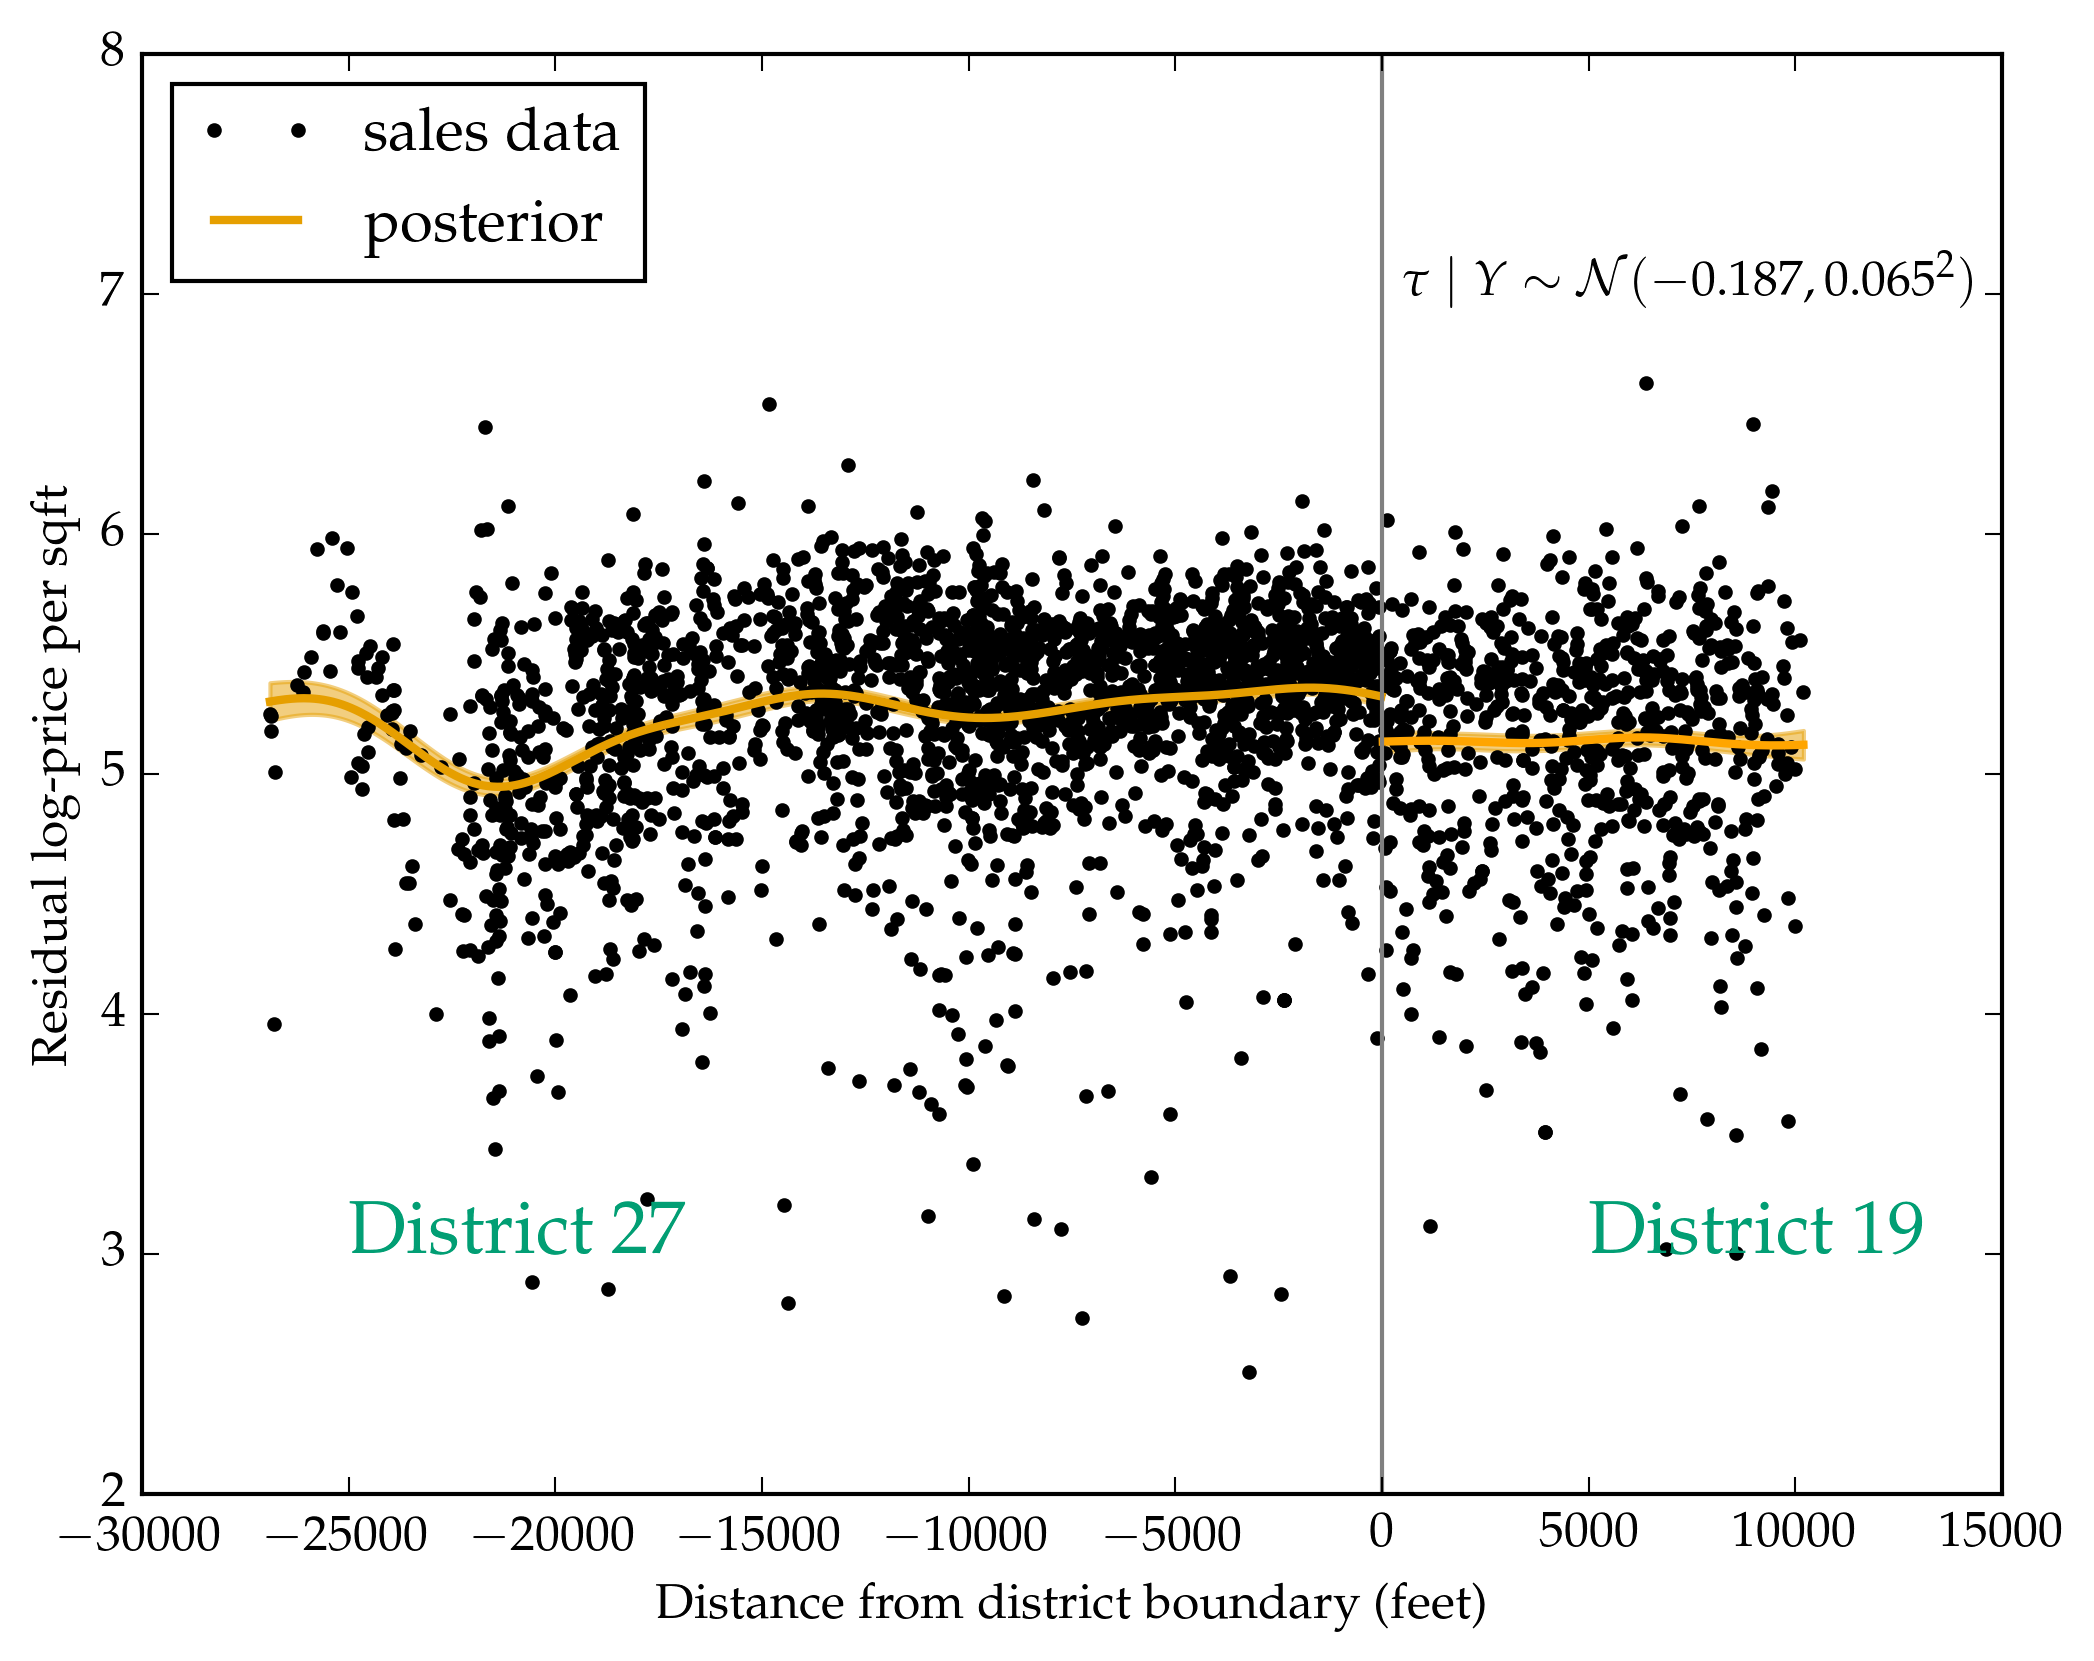

In [19]:
xx=collect(linspace(minimum(X),maximum(X),1000))
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
begin
    xx_left = xx[xx.<0]
    xx_right = xx[xx.>0]
    pred_left =  GaussianProcesses.predict(gp_left, xx_left'; full_cov=false)
    pred_right = GaussianProcesses.predict(gp_right, xx_right'; full_cov=false)
    linear_left = GaussianProcesses.mean(gp_left.m, xx_left')
    linear_right = GaussianProcesses.mean(gp_right.m, xx_right')
    
    plt.plot(vec(X), Y, ".", color="black", label="sales data")
    plt.plot(xx_left, pred_left[1], 
        color=cbbPalette[1], linewidth=2, label="posterior")
    plt.fill_between(xx_left, pred_left[1].-√pred_left[2], pred_left[1].+√pred_left[2], 
        color=cbbPalette[1], alpha=0.5)
    plt.plot(xx_right, pred_right[1], color="orange", linewidth=2)
    plt.fill_between(xx_right, pred_right[1].-√pred_right[2], pred_right[1].+√pred_right[2], 
        color=cbbPalette[1], alpha=0.5)
    plt.axvline(0.0, color="grey")
#     plt.plot(xx_left, linear_left, color=cbbPalette[2], linestyle="-", linewidth=2, label="fitted mean function")
#     plt.plot(xx_right, linear_right, color=cbbPalette[2], linestyle="-", linewidth=2)
    plt.legend(loc="upper left")
    plt.text(-25000, 3, "District 27", color=cbbPalette[3], fontsize=18)
    plt.text(5000,   3, "District 19", color=cbbPalette[3], fontsize=18)
    plt.text(500, 7, join((L"$\tau \mid Y \sim \mathcal{N}(", 
         @sprintf("%.3f, %.3f^2)\$", mean(τpost), std(τpost)))))
    plt.xlabel("Distance from district boundary (feet)")
    plt.ylabel("Residual log-price per sqft")
    plt.savefig("NYC_plots/projeced_19_27_GPMLE.png")
end

In [9]:
@printf("σ_y: %.4f\n", exp(both_gps.logNoise))
@printf("σ_f: %.4f\n", √(both_gps.k.σ2))
@printf("ℓ: %.4f\n", √(both_gps.k.ℓ2))

σ_y: 0.4594
σ_f: 0.1032
ℓ: 2189.6395


In [10]:
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

τ|Y ∼ Normal(μ=-0.187, σ=0.065)
P(τ>0|Y) = 0.195%